# Vision Transformers

In [2]:
%pip install matplotlib torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
import math, random
import torch, numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

# Optional: plotting for attention maps
import matplotlib.pyplot as plt

torch.manual_seed(0)
torch.__version__

'2.8.0'

## From images to sequences: patchifying

A Vision Transformer (ViT) treats an image as a **sequence of patches**. For an image of size $H\times W$ and a square patch size $P$, the number of patches is
$$
N = \frac{H}{P}\cdot\frac{W}{P}.
$$

Each $P\times P$ patch is flattened and linearly projected to a $D$-dimensional embedding. We then add a learnable **class token** and **position embeddings** (1D over patches).

## Patch embedding layer

A compact way to implement patchifying + linear projection is a strided convolution with kernel size $P$ and stride $P$ producing $D$ channels:
$$
\text{PatchEmbed}(x) = \text{Conv2d}(C\rightarrow D,\ \text{kernel}=P,\ \text{stride}=P).
$$


In [4]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=64):
        super().__init__()
        assert img_size % patch_size == 0, "Image size must be divisible by patch size"
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid = img_size // patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        # x: [B, C, H, W] -> [B, N, D]
        x = self.proj(x)                     # [B, D, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)     # [B, N, D]
        return x

# Shape demo
x = torch.randn(2, 3, 32, 32)
pe = PatchEmbed(32, 4, 3, 64)
pe(x).shape

torch.Size([2, 64, 64])

## Class token and positional encodings

We prepend a learned **[CLS]** embedding to the patch sequence. The transformer's output at this position is used for classification via an MLP **head**. We also add **learned** position embeddings $E_{pos}\in\mathbb{R}^{(N+1)\times D}$:
$$
Z_0 = \big[ x_{\text{cls}};\ X E \big] + E_{pos}.
$$


In [5]:
class AddClassTokenAndPos(nn.Module):
    def __init__(self, seq_len, embed_dim):
        super().__init__()
        self.cls = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos = nn.Parameter(torch.zeros(1, seq_len + 1, embed_dim))
        nn.init.trunc_normal_(self.cls, std=0.02)
        nn.init.trunc_normal_(self.pos, std=0.02)
    def forward(self, x):
        B, N, D = x.shape
        cls = self.cls.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)         # [B, N+1, D]
        return x + self.pos[:, :N+1, :]

x = torch.randn(2, 64, 128)  # [B,N,D]
wrapper = AddClassTokenAndPos(seq_len=64, embed_dim=128)
wrapper(x).shape

torch.Size([2, 65, 128])

## Multi-Head Self-Attention (MHSA)

Given $X\in\mathbb{R}^{B\times N\times D}$, we compute queries, keys and values, split into $h$ heads of size $d_h=D/h$:

$$
Q = XW_Q,\quad K = XW_K,\quad V = XW_V,\qquad
\text{Attn}(Q,K,V)=\mathrm{softmax}\!\left(\frac{QK^\top}{\sqrt{d_h}}\right)V.
$$

Concatenate head outputs and project with $W_O$.


In [6]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim=128, num_heads=4, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        assert dim % num_heads == 0
        self.h = num_heads
        self.dh = dim // num_heads
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim, bias=False)
        self.proj_drop = nn.Dropout(proj_drop)
        # for visualization
        self.last_attn = None

    def forward(self, x, mask=None):
        B,N,D = x.shape
        qkv = self.qkv(x).view(B, N, 3, self.h, self.dh).permute(2,0,3,1,4)  # 3, B, H, N, Dh
        Q,K,V = qkv[0], qkv[1], qkv[2]                                       # [B,H,N,Dh]
        scores = (Q @ K.transpose(-2, -1)) / math.sqrt(self.dh)              # [B,H,N,N]
        if mask is not None:
            scores = scores.masked_fill(mask==0, float('-inf'))
        A = scores.softmax(dim=-1)
        self.last_attn = A.detach()  # store for later inspection
        A = self.attn_drop(A)
        y = A @ V                                                         # [B,H,N,Dh]
        y = y.transpose(1,2).contiguous().view(B, N, D)                   # [B,N,D]
        y = self.proj_drop(self.proj(y))                                  # [B,N,D]
        return y

# Quick shape check
mha = MultiHeadSelfAttention(dim=128, num_heads=8)
tok = torch.randn(2, 65, 128)  # include [CLS]
mha(tok).shape

torch.Size([2, 65, 128])

## Transformer encoder block (Pre-LN)

Each block uses residual connections and layer normalization:
$$
X \leftarrow X + \mathrm{MHSA}(\mathrm{LN}(X)),\qquad
X \leftarrow X + \mathrm{MLP}(\mathrm{LN}(X)),
$$
where the MLP is a position-wise 2-layer network with expansion ratio $r$ (e.g., $r=4$).


In [7]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim=128, num_heads=4, mlp_ratio=4, pdrop=0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, num_heads, proj_drop=pdrop)
        self.ln2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim*mlp_ratio),
            nn.GELU(),
            nn.Linear(dim*mlp_ratio, dim),
        )
        self.drop = nn.Dropout(pdrop)
    def forward(self, x):
        x = x + self.drop(self.attn(self.ln1(x)))
        x = x + self.drop(self.mlp(self.ln2(x)))
        return x

blk = TransformerEncoderBlock(dim=128, num_heads=8, mlp_ratio=4, pdrop=0.1)
blk(torch.randn(2, 65, 128)).shape

torch.Size([2, 65, 128])

## Minimal Vision Transformer (ViT)

We combine **PatchEmbed**, **[CLS]+Position**, a stack of encoder blocks, and a **classification head** using the [CLS] output:


In [8]:
class MiniViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10,
                 embed_dim=128, depth=4, num_heads=4, mlp_ratio=4, pdrop=0.0):
        super().__init__()
        self.patch = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        seq_len = (img_size // patch_size) ** 2
        self.add_tokens = AddClassTokenAndPos(seq_len, embed_dim)
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, pdrop)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch(x)             # [B,N,D]
        x = self.add_tokens(x)        # [B,N+1,D]
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        cls = x[:, 0]                 # [B,D]
        return self.head(cls)         # [B,num_classes]

# Shape demo
model = MiniViT(img_size=32, patch_size=4, embed_dim=128, depth=3, num_heads=4, num_classes=5)
demo = torch.randn(4,3,32,32)
model(demo).shape

torch.Size([4, 5])

## Toy example: learn to classify simple synthetic patterns

We create tiny $32\times 32$ images with two classes:
- Class 0: a bright square in the **top-left** quadrant.
- Class 1: a bright square in the **bottom-right** quadrant.

This shows the ViT can learn spatial patterns from patches.


In [9]:
def make_synthetic_dataset(N=512, img_size=32, square=6):
    X = torch.zeros(N, 3, img_size, img_size)
    y = torch.zeros(N, dtype=torch.long)
    for i in range(N):
        cls = random.randint(0,1)
        y[i] = cls
        if cls == 0:
            r0, c0 = 3, 3
        else:
            r0, c0 = img_size - square - 3, img_size - square - 3
        X[i,:, r0:r0+square, c0:c0+square] = 1.0
        # add tiny noise
        X[i] += 0.05*torch.randn_like(X[i])
        X[i].clamp_(0,1)
    return X, y

Xtr, ytr = make_synthetic_dataset(512, 32, square=6)
Xte, yte = make_synthetic_dataset(128, 32, square=6)

model = MiniViT(img_size=32, patch_size=4, embed_dim=128, depth=4, num_heads=4, num_classes=2, pdrop=0.1)
opt = optim.Adam(model.parameters(), lr=3e-3)
for step in range(200):
    idx = torch.randint(0, Xtr.size(0), (64,))
    xb, yb = Xtr[idx], ytr[idx]
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)
    opt.zero_grad(); loss.backward(); opt.step()

with torch.no_grad():
    pred = model(Xte).argmax(-1)
    acc = (pred == yte).float().mean().item()
acc

1.0

## Visualizing an attention map

We grab the last attention matrix from the first block to see how the **[CLS]** token attends to patches.


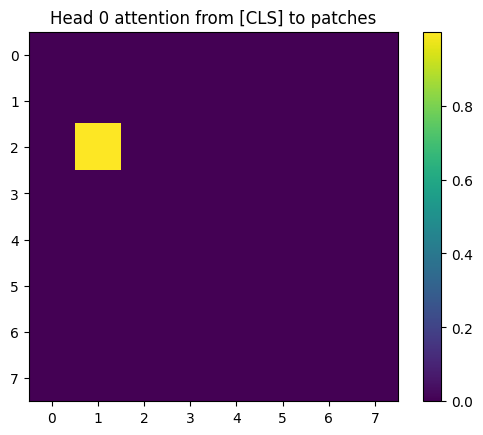

In [10]:
# Forward a small batch and capture attention from the first block
_ = model(Xte[:1])
attn = model.blocks[0].attn.last_attn  # [B,H,N+1,N+1]
attn_cls = attn[0,0,0]                 # head 0, from CLS: [N+1]
L = int(math.sqrt(attn_cls.numel()))   # includes CLS; rough grid viz
# Plot as a square, ignoring the CLS element for nicer layout
fig = plt.figure()
grid = int(math.sqrt(attn_cls.numel()-1))
plt.imshow(attn_cls[1:].view(grid, grid).cpu().numpy())
plt.title("Head 0 attention from [CLS] to patches")
plt.colorbar()
plt.show()

## Effect of patch size on compute

Self-attention cost scales as $\mathcal{O}(N^2)$ with sequence length $N$ (number of patches). For fixed $H,W$:
$$
N = \left(\frac{H}{P}\right)\left(\frac{W}{P}\right)\ \Rightarrow\ \text{cost}\propto N^2 \propto \left(\frac{HW}{P^2}\right)^2.
$$

Below we compare sequence lengths and a proxy for attention cost across patch sizes.


In [11]:
def seq_len_and_cost(img_size=224, patch_sizes=(32,16,14,8)):
    rows = []
    HW = img_size*img_size
    for P in patch_sizes:
        N = (img_size//P)*(img_size//P)
        proxy = (HW/(P*P))**2
        rows.append((P, int(N), int(proxy)))
    return rows

rows = seq_len_and_cost(224, (32,16,14,8))
rows

[(32, 49, 2401), (16, 196, 38416), (14, 256, 65536), (8, 784, 614656)]

## Parameter scaling and common variants

A rough parameter estimate for a ViT-like model with depth $L$, hidden size $D$, MLP ratio $r$, and heads $h$ is dominated by **QKV/O** and **MLP** weights per block:
$$
\text{per-block} \approx 4D^2 \ (\text{Q,K,V,O}) \ + \ 2DrD \ (\text{MLP}).
$$

We add patch projection and classifier head for a coarse total. This helps relate **ViT-Base/Large/Huge** configurations.


In [12]:
def vit_param_estimate(img_size=224, patch=16, in_chans=3, D=768, L=12, r=4, heads=12, num_classes=1000):
    # Patch projection
    patch_params = (in_chans * patch * patch) * D + D  # conv weights + bias
    # Per block: QKV/O ~ 4*D^2, MLP ~ 2*D*r*D
    per_block = 4*D*D + 2*D*r*D
    enc_params = L * per_block
    head_params = D * num_classes + num_classes
    total = patch_params + enc_params + head_params
    return {"patch": patch_params, "encoder_blocks": enc_params, "head": head_params, "total_approx": total}

est_B16 = vit_param_estimate(D=768, L=12, heads=12, patch=16)
est_L16 = vit_param_estimate(D=1024, L=24, heads=16, patch=16)
est_H14 = vit_param_estimate(D=1280, L=32, heads=16, patch=14)
est_B16, est_L16, est_H14

({'patch': 590592,
  'encoder_blocks': 84934656,
  'head': 769000,
  'total_approx': 86294248},
 {'patch': 787456,
  'encoder_blocks': 301989888,
  'head': 1025000,
  'total_approx': 303802344},
 {'patch': 753920,
  'encoder_blocks': 629145600,
  'head': 1281000,
  'total_approx': 631180520})

## Mixing CNNs and Attention (CoAt-style sketch)

Depthwise convolutions excel at local, translation-invariant patterns; attention is **input-adaptive** with global receptive fields. A simple hybrid stacks a few **conv stages** (downsample + depthwise separable conv) followed by **transformer stages**.

Below is a tiny hybrid block showing how you might combine them.


In [13]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, C, expand=4):
        super().__init__()
        self.pw1 = nn.Conv2d(C, C*expand, 1)
        self.dw  = nn.Conv2d(C*expand, C*expand, 3, padding=1, groups=C*expand)
        self.pw2 = nn.Conv2d(C*expand, C, 1)
        self.bn = nn.BatchNorm2d(C)
        self.act = nn.GELU()
    def forward(self, x):
        x = self.pw1(x); x = self.act(self.dw(x)); x = self.pw2(x)
        return self.bn(x)

class TinyHybridStage(nn.Module):
    def __init__(self, C=32, embed_dim=128, num_heads=4, grid=8):
        super().__init__()
        self.down = nn.Conv2d(C, C, 3, stride=2, padding=1)  # downsample
        self.conv = DepthwiseSeparableConv(C)
        self.to_seq = nn.Conv2d(C, embed_dim, 1)
        self.blk = TransformerEncoderBlock(embed_dim, num_heads)
        self.grid = grid//2
    def forward(self, x):
        x = self.down(x)
        x = self.conv(x)
        x = self.to_seq(x)          # [B, D, H', W']
        B,D,H,W = x.shape
        x = x.flatten(2).transpose(1,2)           # [B, N, D]
        x = torch.cat([torch.zeros(B,1,D, device=x.device), x], dim=1)  # add a fake CLS (zero) for demo
        x = self.blk(x)
        return x

hyb = TinyHybridStage(C=16, embed_dim=64, num_heads=4, grid=8)
hyb(torch.randn(2,16,16,16)).shape

torch.Size([2, 65, 64])

## Where to go next

- Swap the synthetic task for a small real dataset and compare patch sizes ($P{=}$8 vs 16).
- Visualize multiple heads/layers to see **attention distance** patterns.
- Try a hybrid: 3 convolutional stages followed by 2 transformer stages.
- Experiment with **relative position bias** in attention (replace absolute positions).

This notebook is designed as a compact **practice companion** to the slides.
